# Kaggle Competition: Digit Recognizer
link: [kaggle competition](https://www.kaggle.com/c/digit-recognizer/overview)

In [1]:
from kaggle_dr_utls import *

In [2]:
PATH_DATA = Path('.')

In [3]:
#!chmod 600 /home/marcau/.kaggle/kaggle.json
#!kaggle competitions download -c digit-recognizer

Import data

In [4]:
data = pd.read_csv(PATH_DATA / "train.csv")
test = pd.read_csv(PATH_DATA / "test.csv")

In [5]:
data.shape, test.shape

((42000, 785), (28000, 784))

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [7]:
target = data.label
train = data.drop('label', axis=1)

Check for missing data

In [8]:
assert (train.isnull().sum().sum() == 0), "there are missing entries"

Let's plot some of the data

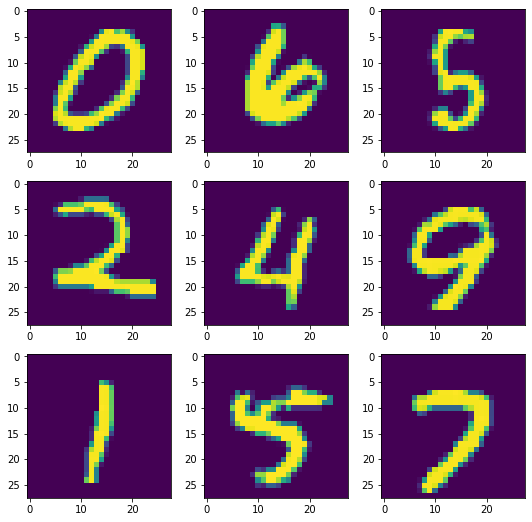

In [9]:
fig, ax = plot_img(train)

We can use PCA to reduce the dimensionality of the input and see how different models perform in both cases (with all the features or with a PCA-found subset).

In [10]:
try:
    pca = pkl.load(open(PATH_DATA / 'pca_dr.pkl', 'rb'))
except FileNotFoundError:
    dims = np.arange(15, 121, 15).astype(int)

    train_norm = Normalizer().fit_transform(train)
    
    exp_var = []
    for dim in dims: 
        print(f'components: {dim}')
        svd = TruncatedSVD(n_components=dim, n_iter=5, random_state=10)
        svd.fit(train_norm)
        exp_var.append(svd.explained_variance_ratio_.sum())

    plt.plot(dims, exp_var, 'r.-')
    plt.plot([15, 120], [0.90, 0.90], 'b-')

    #Find the minimum number of components that explain more than 90% of the variance
    #argmax returns the argmax of the minimum value for which the condition holds
    min_num_components = dims[np.argmax(np.array(exp_var) > 0.9)]
    
    pca = PCA(n_components=min_num_components)

Let's transform the training set with PCA (and back)

In [11]:
train_tr = pca.fit_transform(train)
train_tr_back = pca.inverse_transform(train_tr)

Check how the PCA decomposition is working out on a sample

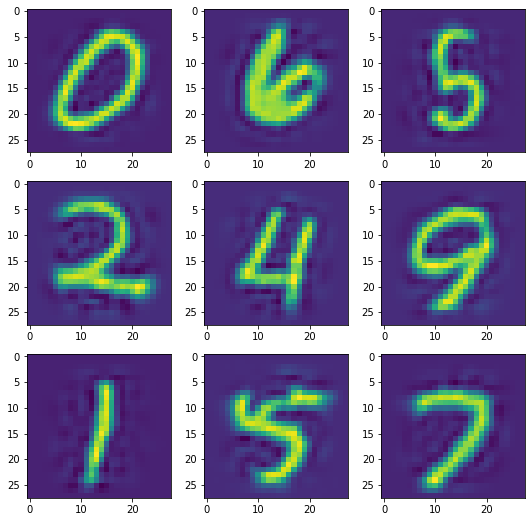

In [12]:
fig, ax = plot_img(train_tr_back)

Save the PCA model

In [13]:
name_model = 'pca_dr'
assert save_model(pca, name_model) == 0, f'something wrong in saving {name_model}'

if not (Path(PATH_DATA / "pca_dr.pkl").is_file()):
    with open('pca_dr.pkl', 'wb') as pickle_file:
            pkl.dump(pca, pickle_file)

## Modeling - Machine Learning

Before using Neural Networks, let's see what we can do using some classical ML algorithms

### Non-Ensemble Methods

Let's try with Logistic Regression 

In [14]:
model = LogisticRegression()
name_model = 'lr_dr'
try_model(train_tr, target, model, name_model)

model: lr_dr
train score: 0.9207
test score: 0.9101


In [15]:
assert create_subfile_dr(test, pca, model, name_model) == 0,\
'something went wrong while creating the submission file'

KNN

In [16]:
model = KNeighborsClassifier()
name_model = 'knn_dr'
try_model(train_tr, target, model, name_model)

model: knn_dr
train score: 0.9801
test score: 0.9694


SVC

In [17]:
model = SVC(kernel='rbf')
name_model = 'svc_rbf_dr'
try_model(train_tr, target, model, name_model)

SVC()
model: svc_rbf_dr
train score: 0.9919
test score: 0.9790


In [18]:
assert create_subfile_dr(test, pca, model, name_model) == 0,\
'something went wrong while creating the submission file'

In [40]:
!kaggle competitions submit -c digit-recognizer -f \
     "submission_{name_model}.csv" -m 'submission of {name_model} model'

100%|████████████████████████████████████████| 208k/208k [00:03<00:00, 60.7kB/s]
Successfully submitted to Digit Recognizer

### Ensemble Methods

Let's now use Random Forest on the reduced dataset

In [19]:
model = RandomForestClassifier()
name_model = 'rf_dr'
try_model(train_tr, target, model, name_model)

model: rf_dr
train score: 1.0000
test score: 0.9433


In [20]:
assert create_subfile_dr(test, pca, model, name_model) == 0, 'something went wrong with the submission'

In [ ]:
!kaggle competitions submit -c digit-recognizer -f \
     "submission_{name_model}.csv" -m 'submission of {name_model} model'

Let's use Extra Trees on the reduced dataset

In [21]:
model = ExtraTreesClassifier()
name_model = 'ext_dr'
try_model(train_tr, target, model, name_model)

model: ext_dr
train score: 1.0000
test score: 0.9482


In [22]:
assert create_subfile_dr(test, pca, model, name_model) == 0, 'something went wrong with the submission'

In [ ]:
!kaggle competitions submit -c digit-recognizer -f \
     "submission_{name_model}.csv" -m 'submission of {name_model} model'

Now let's use a Hard Voting Classifier 

In [ ]:
model = VotingClassifier(estimators=[('svc', SVC(kernel='rbf')), \
('lr', LogisticRegression()), ('dt', DecisionTreeClassifier()),\
('gnb', GaussianNB()), ('knn', KNeighborsClassifier())], \
voting='hard', n_jobs=-3, verbose=True)

name_model = 'hv_clf_dr'
try_model(train_tr, target, model, name_model)

model: hv_clf_dr


In [27]:
assert create_subfile_dr(test, pca, model, name_model, PATH_) == 0, 'something went wrong with the submission'

In [29]:
!kaggle competitions submit -c digit-recognizer -f \
     "submission_{name_model}.csv" -m 'submission of {name_model} model'

100%|████████████████████████████████████████| 208k/208k [00:03<00:00, 66.8kB/s]
Successfully submitted to Digit Recognizer

Soft Voting Classifier

In [ ]:
model = VotingClassifier(estimators=[('svc', SVC(kernel='rbf', probability=True)), \
('lr', LogisticRegression()), ('dt', DecisionTreeClassifier()),\
('gnb', GaussianNB()), ('knn', KNeighborsClassifier())], \
voting='soft', n_jobs=-3, verbose=True)

name_model = 'sv_clf_dr'
try_model(train_tr, target, model, name_model)

In [34]:
assert create_subfile_dr(test, pca, model, name_model, PATH_DATA) == 0, 'something went wrong with the submission'

In [35]:
!kaggle competitions submit -c digit-recognizer -f \
     "submission_{name_model}.csv" -m 'submission of {name_model} model'

100%|████████████████████████████████████████| 208k/208k [00:03<00:00, 65.3kB/s]
Successfully submitted to Digit Recognizer

Let's now use Bagging with SVC and different kernels (we have used RBF and polynomial kernel with degree=3)

In [14]:
kernel = 'poly'
model = BaggingClassifier(base_estimator=SVC(kernel=),\
n_estimators=15, oob_score=True, n_jobs=-2, random_state=21, verbose=1)
name_model = f'bag_svc_ker{kernel}_dr'
try_model(train_tr, target, model, name_model,\
score=False)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:  2.4min remaining:  5.9min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:  3.0min finished
/home/marcau/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/marcau/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


We can get an estimate of the accuracy oob_score_

In [ ]:
model.oob_score_

In [ ]:
assert create_subfile_dr(test, pca, model, name_model) == 0, 'something went wrong with the submission'

In [17]:
!kaggle competitions submit -c digit-recognizer -f \
     "submission_{name_model}.csv" -m 'submission of {name_model} model'

100%|████████████████████████████████████████| 208k/208k [00:04<00:00, 48.9kB/s]
Successfully submitted to Digit Recognizer

## Grid Search

We have seen that Random Forest and Extra Trees do not perform well among the ensemble methods, in the sense that they are clearly overfitting to the dataset. We can grid search parameters for these two models using cross validation, so as to find a combination that will strike a good balance between over- and underfitting.

In [22]:
%%time
param_grid = {'n_estimators': [20, 50, 100, 150], 
              'min_samples_split': [2, 5, 10],
              'max_depth': [4, 7, 10]}

model = RandomForestClassifier()
name_model = 'gscvBE_rf_dr'
gscv = GridSearchCV(model, param_grid=param_grid,\
scoring='accuracy', cv=4, n_jobs=-3, verbose=1)

try:
    gscvBestEst = pkl.load(open(PATH_DATA / f'{name_model}.pkl', 'rb'))
except:
    gscv.fit(train_tr, target)
    gscvBestEst = gscv.best_estimator_

CPU times: user 102 ms, sys: 79.2 ms, total: 181 ms
Wall time: 348 ms


In [23]:
if not (Path(PATH_DATA / f"{name_model}.pkl").is_file()):
    with open(f'{name_model}.pkl', 'wb') as pickle_file:
            pkl.dump(gscvBestEst, pickle_file)

In [24]:
gscvBestEst.score(train_tr, target)

0.9547142857142857

In [25]:
assert create_subfile_dr(test, pca, model, name_model) == 0,\
'something went wrong in creating the submission file'

In [26]:
!kaggle competitions submit -c digit-recognizer -f \
     "submission_{name_model}.csv" -m 'submission of {name_model} model'

100%|████████████████████████████████████████| 208k/208k [00:03<00:00, 63.8kB/s]
Successfully submitted to Digit Recognizer

In [28]:
gscvBestEst.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}